## Document Scanning using skimage 

Add util folder to the path

In [1]:
%load_ext autoreload 
%autoreload 2
import sys

sys.path.append("../util")

import neccessary dependencies

In [2]:
from plot import plot_images
from skimage.io import imread
from skimage.transform import rescale
from skimage.morphology import closing
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt
import numpy as np

Read the image and scale it down to reduce computational expences

In [3]:
scaling_factor = .25
img_path = "../images/example_0.jpg"

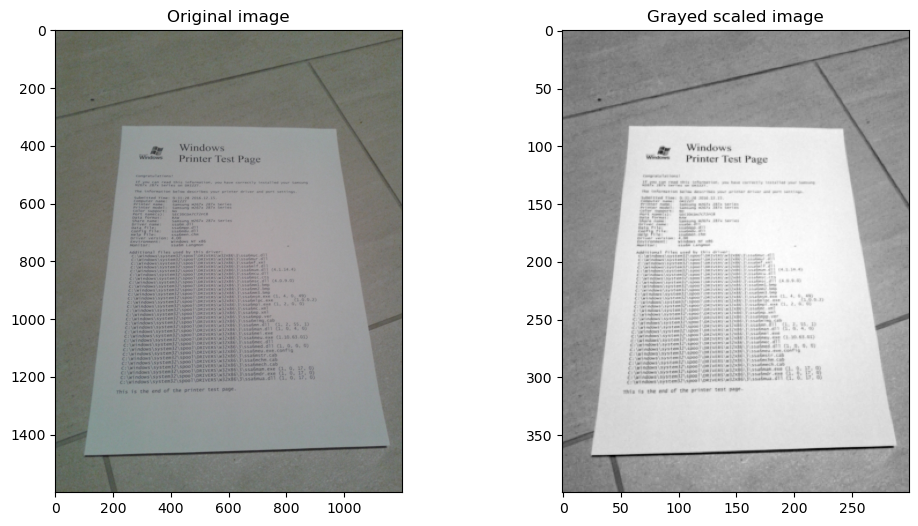

In [ ]:
img = imread(img_path)
working_img = rescale(img, scaling_factor, channel_axis=2)
working_img = rgb2gray(working_img[:, :, :3])

_ = plot_images([(img, "Original image"), (working_img, "Grayed scaled image", plt.cm.gray)], figsize=(12,6))

Use closing and gaussian blur as preprocessing steps to remove noise and thins like text

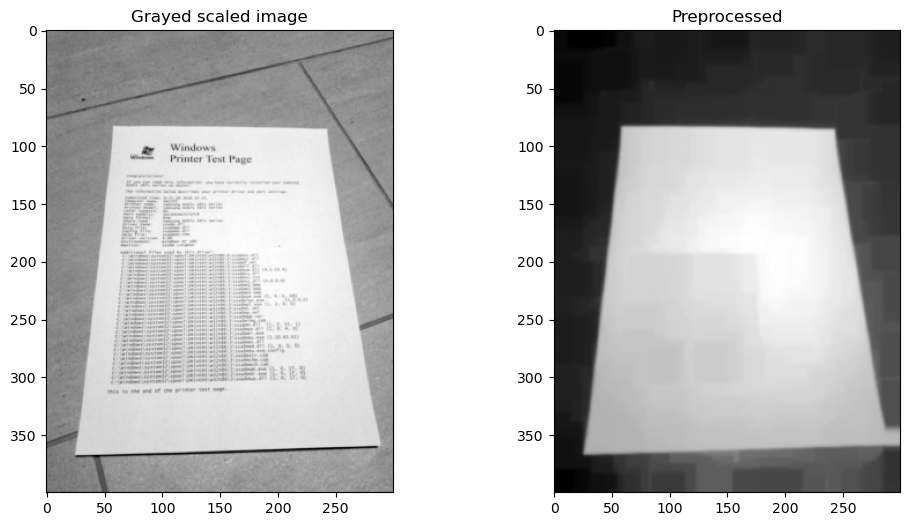

In [5]:
preprocess_img = closing(working_img, footprint=[(np.ones((27, 1)), 1), (np.ones((1, 27)), 1)])
preprocess_img = gaussian(preprocess_img, sigma=1.2)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (preprocess_img, "Preprocessed", plt.cm.gray)], figsize=(12,6))

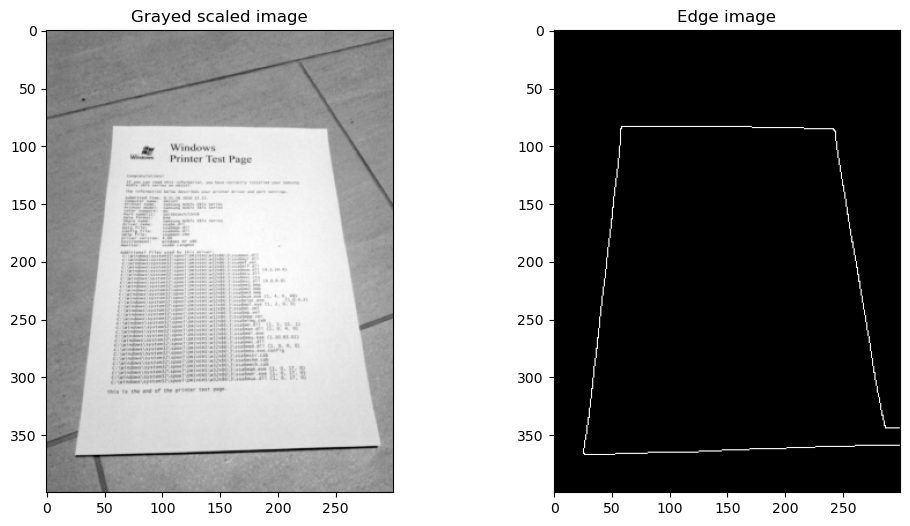

In [6]:
edge_image = canny(preprocess_img)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (edge_image, "Edge image", plt.cm.gray)], figsize=(12,6))

With the now final preprocessed image, 
1. use hough transform to find lines which would correspond to the edges of the document, in the image.
2. find the corners by calculating the intersection points of the lines
3. if less then 4 corners are found, redo step 1 but allow for one more line to be found
4. if more then 4 corners are found, choose the 4 corners that are closest to be in a 90° angle 

In [7]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edge_image, theta=tested_angles)

Searching for 4 lines: found 4 corners


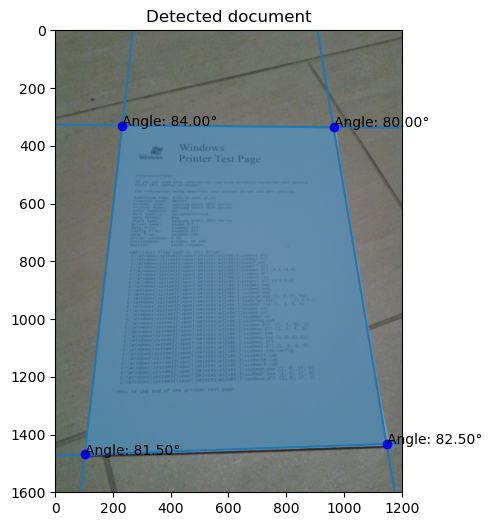

In [ ]:
from geometry import line_intersections, rescale_point

def find_corners(max_peaks : int):
    hough_lines = []
    # for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=max_peaks, threshold=.4*max([max(a) for a in h]))):
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=max_peaks)):
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        slope = np.tan(angle + np.pi / 2)
        hough_lines.append((x0, y0, slope))

    intersections = line_intersections(hough_lines)
    
    # filter intersection points that are either inside the image or within an epsilon margin defined as a percentage of the image dimensions. The epsilon value allows intersections
    # near the image edges to be included.
    epsilon = .1
    epsilon_y, epsilon_x = epsilon * np.array(working_img.shape)
    max_y, max_x = working_img.shape
    max_y, max_x = max_y + epsilon_y, max_x + epsilon_x
    intersections = [inter for inter in intersections if -epsilon_x <= inter[0][0] <= max_x and -epsilon_y <= inter[0][1] <= max_y ]
    if len(intersections) == 0:
        return [], [], hough_lines

    # get the corner points in counter clockwise order starting form 3. Quadrant (bottom left)
    corners, angle = list(zip(*[(rescale_point(point, working_img.shape, img.shape[:-1]), angle) for point, angle, *_ in intersections]))
    return corners, angle, hough_lines

max_peaks = 4
while True:
    corners, angles, hough_lines = find_corners(max_peaks) 
    print(f"Searching for {max_peaks} lines: found {len(corners)} corners")
    if len(corners) >= 4:
        break
    max_peaks += 1

# find the best 4 corners (closest to 90° angles)
if len(corners) > 4:
    ord = np.argsort(np.abs(90 - np.abs(angles)))
    corners = np.array(corners)[ord][:4]

corners = np.array(corners)
centroid = np.mean(corners, axis=0)

# sort the corners in counter clockwise order starting form the 3. Quadrant
# since matplotlib coords start in the topleft corner and the y axis is positive downwards the Quadrants are mirrored horizontally
centroid_angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])
corners = np.array(corners)[np.argsort(centroid_angles)]
angles = np.array(angles)[np.argsort(centroid_angles)]

fig, ax = plot_images([(img, "Detected document", plt.cm.gray)], figsize=(12,6), limit_axis=True)

ax[0].fill(*zip(*corners), fill="b", alpha=.5, linewidth=0)

for x0, y0, slope in hough_lines:
    x0, y0 = rescale_point((x0, y0), working_img.shape, img.shape[:-1])
    ax[0].axline((x0, y0), slope=slope)

for (x, y), angle in zip(corners, angles):
    ax[0].text(x, y, f"Angle: {abs(angle):.2f}°")
    ax[0].plot(x, y, "bo")

Define width and height of the warped image

In [9]:
from geometry import euclidean_distance

# get the average size of the parallel sides of the document
horizontal_side_avg = int(np.average([euclidean_distance(corners[0], corners[1]), euclidean_distance(corners[2], corners[3])]))
vertical_side_avg = int(np.average([euclidean_distance(corners[0], corners[3]), euclidean_distance(corners[1], corners[2])]))

# define the shortest side as the width and the larger side as the height
sides = [horizontal_side_avg, vertical_side_avg]
shortest_idx = np.argmin(sides)
width = sides[shortest_idx]
height = max(sides)

# if the vertical side is the smallest the document is orientated in landscape and needs to be rotated 
in_landscape_position = shortest_idx == 1

Using the orientation (landscape or portrait) of the document, mark each corner with the fitting position. Right now it can't correctly a document that is "upside down" in portrait or landscape orientation

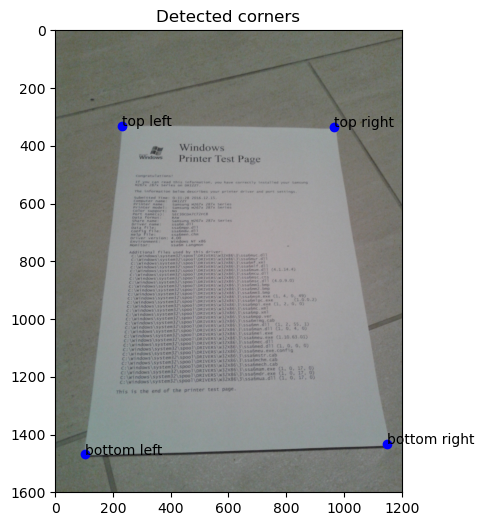

In [10]:
# specify the order starting from top left counterclockwise order
corner_order = [1, 0, 3, 2] if in_landscape_position else [0, 3, 2, 1]

fig, ax = plot_images([(img, "Detected corners", plt.cm.gray)], figsize=(12,6), limit_axis=True)

# order is bottom left counter clockwise but since the image positive y axis is facing downwards topleft is the first point here 
ccw_corners = corners[corner_order]
labels = ["top left", "bottom left", "bottom right", "top right"]
for i, ((x, y), label) in enumerate(list(zip(ccw_corners, labels))):
    ax[0].text(x, y, label) 
    ax[0].plot(x, y, "bo")

Warp the image to a top down perspective

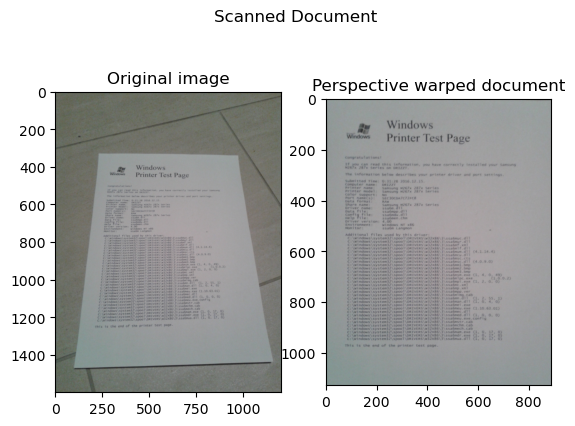

In [11]:
from skimage.transform import ProjectiveTransform, warp
from skimage.segmentation import flood_fill

# 0 0 is top left origin
src = np.array([[0,0], [0, height], [width, height], [width, 0]])
dst = ccw_corners.copy()


projectiveTransform = ProjectiveTransform()
projectiveTransform.estimate(src, dst)
warped = warp(img, projectiveTransform, output_shape=(height, width), mode="constant", cval=1)
warped = (warped * 255).astype(np.uint8)

fig, ax = plot_images([(img, "Original image"), (warped, "Perspective warped document")], title="Scanned Document")

In [12]:
from skimage.io import imsave
from os import path

imsave(f"../out/{path.basename(img_path).split(".")[0]}_scanned_document.png", warped)